# Statistical foundation of machine learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys

sys.path.append("../")

# adjust import if needed

## (Optional) Signal filtering

if you plan to filter your sEMG signals, it is recommended to perform
this preprocessing step directly on the continuous raw data prior to window extraction or feature
computation. Note that this step is completely optional but may improve your results.

## (0.5 point) Dataset preparation and augmentation through overlapping windows

You should first segment your sEMG signals into smaller windows of fixed size k = 500. These windows should be created with a chosen degree of overlap, which you can adjust based on the computational and memory resources available to you. Keep in mind that a larger overlap results in a greater number of samples and thus a larger dataset to train your models but to the cost of increasing computational demands.

### Loading raw data

In [2]:
# loading raw data
# PATH = f'/Users/marco/PROJECTS/data/'
PATH = r"D:/Uni/F422/F422/F422 EMG project data/"
# PATH = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project\data\\'
DATASET = 'guided' # change this to guided/freemoves if needed

X_guided = np.load(PATH + f'{DATASET}/{DATASET}_dataset_X.npy')
Y_guided = np.load(PATH + f'{DATASET}/{DATASET}_dataset_Y.npy')

DATASET = 'freemoves' # change this to guided/freemoves if needed

X_freemoves = np.load(PATH + f'{DATASET}/{DATASET}_dataset_X.npy')
Y_freemoves = np.load(PATH + f'{DATASET}/{DATASET}_dataset_Y.npy')

### Overlapping windows
To prepare our dataset for regression tasks, we segment the continuous surface electromyography (sEMG) signals into smaller overlapping windows of fixed size. This preprocessing step is crucial as it enables the learning models to capture localized temporal patterns in muscle activity and link them to corresponding hand pose estimations.

We chose a **window size `k = 500` samples**, which corresponds to roughly **0.49 seconds** of sEMG data, given the sampling rate of **1024 Hz**. This window size strikes a balance between capturing enough signal dynamics and ensuring real-time usability for prosthesis control.

We implemented a **50% overlap**, meaning each window starts 250 samples after the previous one. This overlap increases the number of training samples without excessively inflating computational costs. Larger overlaps (e.g., 75%) generate even more samples but demand significantly more memory and processing time, which may not scale efficiently depending on available resources.

This approach is implemented using two custom transformer classes:
- `TimeWindowTransformer`: Applies sliding windows to the raw sEMG signals.
- `LabelWindowExtractor`: Aligns the corresponding joint angle labels by sampling at the end of each time window.

This transformation ensures consistent alignment between each input window and its output label, facilitating supervised learning.

In [3]:
from config.transformers import TimeWindowTransformer, LabelWindowExtractor

# Define parameters
size = 500
step = 250

# Initialize transformers
tw_transformer = TimeWindowTransformer(size=size, step=step)
label_extractor = LabelWindowExtractor(size=size, step=step)

# Apply transformations
X_guided_windows = tw_transformer.transform(X_guided)     # shape: (5, n_windows, 8, 500)
Y_guided_labels = label_extractor.transform(Y_guided)     # shape: (5, n_windows, 51)

X_freemoves_windows = tw_transformer.transform(X_freemoves)     # shape: (5, n_windows, 8, 500)
Y_freemoves_labels = label_extractor.transform(Y_freemoves)     # shape: (5, n_windows, 51)

# Inspect shapes
print("guided:")
print("X_windows shape:", X_guided_windows.shape)
print("Y_labels shape:", Y_guided_labels.shape)
print("freemoves:")
print("X_windows shape:", X_freemoves_windows.shape)
print("Y_labels shape:", Y_freemoves_labels.shape)

guided:
X_windows shape: (5, 919, 8, 500)
Y_labels shape: (5, 919, 51)
freemoves:
X_windows shape: (5, 1079, 8, 500)
Y_labels shape: (5, 1079, 51)


## (1 point) Cross-validation strategy

Determine and implement an adequate cross-validation strategy to validate your regression models, specifying how you organized your data partitions for training and validation. Provide a detailed justification showing that your validation sets remain completely independent from the training set. Include reasoning or evidence demonstrating explicitly that your chosen partitioning strategy prevents data leakage or bias, ensuring the reliability and generalizability of your model performance estimates.

### Leave-One-Session-Out cross-validation
To rigorously evaluate the performance and generalization capabilities of our regression models, we implemented a **cross-validation strategy** that ensures independence between training and validation data and avoids data leakage.

The available data consists of 5 recording sessions. We use the first **4 sessions** (`X_train_val_folds`, `Y_train_val_folds`) for training and validation, and **reserve the 5th session** (`X_test`, `Y_test`) as a completely unseen test set. This separation allows us to simulate real-world scenarios where the model encounters entirely new data from the same participant.

In [4]:
X_train_val_folds = X_windows[:4]
Y_train_val_folds = Y_labels[:4]
X_test = X_windows[4]
Y_test = Y_labels[4]

Within the five training sessions, we assess the estimator performance by training it on four out of the five sessions of all participants and evaluating it on the “holdout” sessions that the model has never seen. To prevent bias due to potential sessions’ specificities, we use a **Leave-One-Session-Out cross-validation**. The final estimator performance is computed as he root mean squared error (**RMSE**) and normalized mean squared error (**NMSE**) across all five cross validated estimators. This strategy ensures:

- **Complete independence** between training and validation data in each fold
- Robust estimation of the model's performance across different recording sessions
- Reduced risk of overfitting to session-specific artifacts

This strategy provides insights into an estimator’s capacity to generalize to unseen data from new sessions of the same participants. However, it does not provide any information on the estimator’sability to generalize to data from new unseen participants.

> To select the best-performing model configuration, we initially restricted our training data to **only four of the five sessions**. This allowed us to **keep one session completely held out** for **final testing** of generalization on entirely unseen data. Once the optimal model and hyperparameters were selected, we **retrained and validated the model across all five sessions** using the strategy described above. This gave a more complete and reliable estimate of how well the final model generalizes across session variability.

We implemented this strategy creating a 'cross_validate_pipeline' utility function to handle the fold-based evaluation of any sklearn-compatible pipeline:

- Trains on 4 sessions and validates on the 5th (rotating fold)
- Reports both training and validation scores for each fold
- Computes mean performance across all folds for better interpretability

## (3 points) Baseline approach

Create a custom class inheriting from scikit-learn’s `BaseEstimator`
and `TransformerMixin` that implements the extraction of common time-domain features described
in section 3.1. Note that the features described in Section 3.1 represent the minimal required set. We
encourage you to include additional features or preprocessing steps if you would like to further improve your model performances. Select at least two different regression models, compare their cross-validated performance, and evaluate their feature importances. For both models, perform feature selection to determine the optimal subset of features minimizing the Root Mean Squared Error (RMSE).
Clearly document this process in your notebook, discussing the outcomes in detail. Finally, create a
scikit-learn `Pipeline` that integrates your custom feature extraction class, the optimal feature selection step, and the best-performing regression model identified from your cross-validation results.
Using visualizations and tables to illustrate your findings, and employing formulas or pseudo-code
to explain the feature selection procedure, is strongly encouraged. Note that one-third of the score
will depend on the quality and clarity of your documentation.

### Time-domain features
To establish a robust performance benchmark, we designed a baseline approach that uses standard time-domain features extracted from the raw sEMG signal windows. These features have been widely used in EMG-based regression problems due to their low computational cost and effectiveness in capturing muscle activity dynamics.

We created a custom class `TimeDomainTransformer`, inheriting from `BaseEstimator` and `TransformerMixin`, to extract 12 key time-domain features from each EMG channel over a signal window of 500 samples.
These features are computed along the time dimension and include:

- **MAV** – Mean Absolute Value
- **RMS** – Root Mean Square
- **VAR** – Variance
- **STD** – Standard Deviation
- **ZC** – Zero Crossing Count
- **MPR** – Myopulse Percentage Rate (using a tunable threshold `sigma_mpr`)
- **MAA** – Maximum Absolute Amplitude
- **WL** – Waveform Length
- **SSC** – Slope Sign Changes
- **WA** – Wilson Amplitude
- **MFL** – Maximum Fractal Length
- **KRT** – Kurtosis

Each channel of the EMG window (8 in total) produces 12 features, resulting in a final feature vector of size **96** per window.

### Baseline approach
We constructed three baseline pipelines using different regression algorithms to evaluate how well standard time-domain features can predict hand articulation from sEMG signals.

Each pipeline follows the same general structure:

1. **Feature Extraction**  
   Extracts 12 physiological descriptors from each EMG channel using the custom `TimeDomainTransformer`.

2. **Standardization**  
   Normalizes the extracted features using `StandardScaler` to ensure each feature contributes equally to the regression model.

3. **Regression Model**  
   Each pipeline uses a different learning algorithm:
   - **Kernel Ridge Regression** with a Laplacian kernel
   - **K-Nearest Neighbors Regression**
   - **Random Forest Regression**

#### Tuning
To improve the performance of each baseline model, we performed **manual hyperparameter tuning** using an exhaustive grid search strategy. This process is implemented in a dedicated notebook, `tuning_baseline.ipynb`, and applied independently to each pipeline.

For each model, we defined a tailored parameter grid and evaluated all combinations using our cross-validation procedure. The objective is to identify the configuration that minimizes the **validation RMSE**, while also tracking **NMSE** for robustness.

Below is a summary of the parameter grids explored:

- **Time Domain Features + Kernel Ridge**
  - `alpha`: regularization strength
  - `gamma`: kernel coefficient
  - `kernel`: type of kernel (`rbf`, `laplacian`, `poly`)

- **Time Domain Features + KNN**
  - `n_neighbors`: number of nearest neighbors
  - `weights`: uniform or distance-based weighting

- **Time Domain Features + Random Forest**
  - `n_estimators`: number of trees in the forest
  - `max_depth`: depth of each tree
  - `min_samples_split`: minimum samples required to split a node
  - `min_samples_leaf`: minimum samples at a leaf node

Each model is tuned using the following loop:

```python
for model_name, pipeline in models.items():
    print(f"\nTuning Model: {model_name}") 
    results = []

    for params in ParameterGrid(param_grids[model_name]):
        pipeline.set_params(**params)
        scores = cross_validate_pipeline(pipeline, X_train_val_folds, Y_train_val_folds, metric_fns)

        results.append({
            'params': params,
            'mean_train_RMSE': scores['avg_train_RMSE'],
            'mean_val_RMSE': scores['avg_val_RMSE'],
            'mean_train_NMSE': scores['avg_train_NMSE'],
            'mean_val_NMSE': scores['avg_val_NMSE']
        })

    all_results[model_name] = results
```

The results are saved in a seperate json file, allowing us to later analyze the best hyperparameter configuration per model. This tuning step ensures that our baselines are not only functional but also reasonably optimized for performance.

> **DISCLAIMER**

All models and pipelines developed in this project adhere to the following input/output shape requirements to ensure compatibility with the dataset and evaluation routines:

- `model.fit(X, y)`  
  - **Input:**  
    - `X`: NumPy array of shape **(N, 8, 500)** — N windows of raw sEMG signals (8 channels, 500 samples each)  
    - `y`: NumPy array of shape **(N, 51)** — Corresponding joint-angle labels
  - **Note:** This method fits the model in place; the return value is not used.

- `model.predict(X)`  
  - **Input:** `X` of shape **(N, 8, 500)**  
  - **Output:** NumPy array of shape **(N, 51)** — Predicted joint angles

Custom transformers (e.g., for feature extraction) should implement the `fit_transform()` method:
- **Input:** `X` of shape **(N, 8, 500)**
- **Output:** Transformed feature array of shape **(N, ...)**, depending on the specific transformer logic

#### Baseline models - guided

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge

from config.transformers import TimeDomainTransformer
from config.validation import RMSE, NMSE, cross_validate_pipeline

In [6]:
baseline_guided_kr = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', KernelRidge(
            alpha = 0.01,
            gamma = 0.01,
            kernel='laplacian'))
    ]
)

baseline_guided_knn = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', KNeighborsRegressor(
            n_neighbors = 5))
    ]
)

baseline_guided_rf = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(
            n_estimators = 50,
            max_depth = 10))
    ]
)

#### Baseline evaluation

To evaluate these baselines, we applied the **4-fold cross-validation** strategy described previously. For each model, we report both:

- **Root Mean Squared Error (RMSE)**: Measures the average magnitude of prediction errors.
- **Normalized Mean Squared Error (NMSE)**: Indicates performance relative to the variance of the true joint angles.

This setup allows us to compare model performance on a consistent, unbiased basis and analyze the robustness of each approach.

In [7]:
# Evaluation
metric_fns = {'RMSE': RMSE, 'NMSE': NMSE}
models = {
    'Time domain features + Kernel Ridge': baseline_guided_kr,
    'Time domain features + KNN': baseline_guided_knn,
    'Time domain features + Random Forests': baseline_guided_rf
}

for model_name, model in models.items():
    print(f'\nModel: {model_name}')
    result = cross_validate_pipeline(model, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=1)


Model: Time domain features + Kernel Ridge

Average Scores across folds:
RMSE: train=0.1764, val=5.1763
NMSE: train=0.0002, val=0.1354

Model: Time domain features + KNN

Average Scores across folds:
RMSE: train=2.0971, val=4.7569
NMSE: train=0.0219, val=0.1144

Model: Time domain features + Random Forests

Average Scores across folds:
RMSE: train=1.9944, val=5.1086
NMSE: train=0.0198, val=0.1331


#### Features selection
In order to perform feature selection to determine the optimal subset of features minimizing the Root Mean Squared Error (RMSE) we implemeted 2 appraoches: **mRMR (Minimum Redundancy Maximum Relevance)** and **PCA**

##### mRMR
This section explains how features are ranked and selected using the **Minimum Redundancy Maximum Relevance (mRMR)** strategy, based on a correlation-based approximation of mutual information.
To estimate the relevance of each feature to the outputs (joint angles), we approximate **Mutual Information (MI)** using the correlation coefficient:

$$
\text{MI}(x, y) \approx -\frac{1}{2} \log(1 - \rho^2)
$$

Where:
- $\rho$ is the **Pearson correlation coefficient**
- This approximation assumes **joint Gaussianity**

```python
def mutual_info_corr(x, y):
    """
    Approximates mutual information between x and y via Pearson correlation.
    """
    c = np.corrcoef(x, y)[0, 1]
    if abs(c) == 1:
        c = 0.999999  # avoid division by zero
    return -0.5 * np.log(1 - c**2)
```

The algorithm iteratively selects the next feature that maximizes:
\[
\text{mRMR}_j = \text{Relevance}_j - \text{Redundancy}_j
\]

Where:
- **Relevance**: average MI between the candidate feature and all outputs
- **Redundancy**: average MI between the candidate and all already-selected features

```python
def greedy_mrmr_selection(X_df, mi_scores):
    selected = []
    candidates = list(range(X_df.shape[1]))

    for _ in range(len(candidates)):
        redundancy = ...
        mrmr_score = mi_scores[candidates] - redundancy
        best = candidates[np.argmax(mrmr_score)]
        selected.append(best)
        candidates.remove(best)
    return selected
```

For each subset of selected features from size 1 to N:
- Build a scikit-learn pipeline with the regressor
- Use cross_validate_pipeline() to compute the average RMSE across folds
- Evaluate mean Validation RMSE per fold

After evaluating all subsets, a plot is created showing RMSE (with error bars) as features are added together with dot colors indicating the type of time-domain feature (e.g., MAV, RMS, etc.)

In [ ]:
from config.validation import mutual_info_corr, compute_mi_vector, greedy_mrmr_selection
from config.transformers import FeatureSelector

# Compute Mutual Info (includes feature extraction)
X_df, Y_all, mi_scores, X_sessions = compute_mi_vector(X_train_val_folds, Y_train_val_folds, TimeDomainTransformer(sigma_mpr=0.3))

# Perform mRMR
selected = greedy_mrmr_selection(X_df, mi_scores)

# Evaluation
n_features = len(selected)
n_sessions = X_sessions.shape[0]
CV_err_mrmr = np.zeros((n_features, n_sessions))

for nb_features in range(1, n_features + 1):
    selected_indices = selected[:nb_features]
    pipeline = Pipeline([
        ('select', FeatureSelector(selected_indices)),
        ('scale', StandardScaler()),
        ('reg', KernelRidge(
            alpha=0.01, 
            gamma=0.01, 
            kernel='laplacian'))
    ])
    cv_results = cross_validate_pipeline(
        pipeline, 
        X_sessions, 
        Y_train_val_folds,
        metric_fns={'RMSE': RMSE}, 
        n_folds=n_sessions, 
        verbose=0
    )
    for fold_id in range(n_sessions):
        CV_err_mrmr[nb_features - 1, fold_id] = cv_results[fold_id]['val_RMSE']

# Report results
print("\nmRMR Feature Selection with Kernel Ridge")
for i in range(n_features):
    print(f"#Features: {i+1}; CV error = {CV_err_mrmr[i,:].mean():.4f}; std dev = {CV_err_mrmr[i,:].std():.4f}")

print("\nSelected feature ranking (by column index):")
print(selected)



mRMR Feature Selection with Multi-Output Regression
#Features: 1; CV error = 12.1624; std dev = 0.1727
#Features: 2; CV error = 10.3837; std dev = 0.5100
#Features: 3; CV error = 9.9987; std dev = 0.6440
#Features: 4; CV error = 9.7973; std dev = 0.7752
#Features: 5; CV error = 9.6121; std dev = 0.7060
#Features: 6; CV error = 9.5482; std dev = 0.8101
#Features: 7; CV error = 9.5838; std dev = 0.8135
#Features: 8; CV error = 9.1600; std dev = 0.6959
#Features: 9; CV error = 9.1415; std dev = 0.6667
#Features: 10; CV error = 7.2972; std dev = 0.8519
#Features: 11; CV error = 7.3302; std dev = 0.8226
#Features: 12; CV error = 7.3476; std dev = 0.8073
#Features: 13; CV error = 7.0713; std dev = 0.6807
#Features: 14; CV error = 7.0493; std dev = 0.6829
#Features: 15; CV error = 7.0057; std dev = 0.6790
#Features: 16; CV error = 7.0285; std dev = 0.6924
#Features: 17; CV error = 6.3715; std dev = 0.6095
#Features: 18; CV error = 6.3611; std dev = 0.6115
#Features: 19; CV error = 6.3987; st

C:\Users\gianm\AppData\Local\Temp\ipykernel_50676\2031987167.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_types))


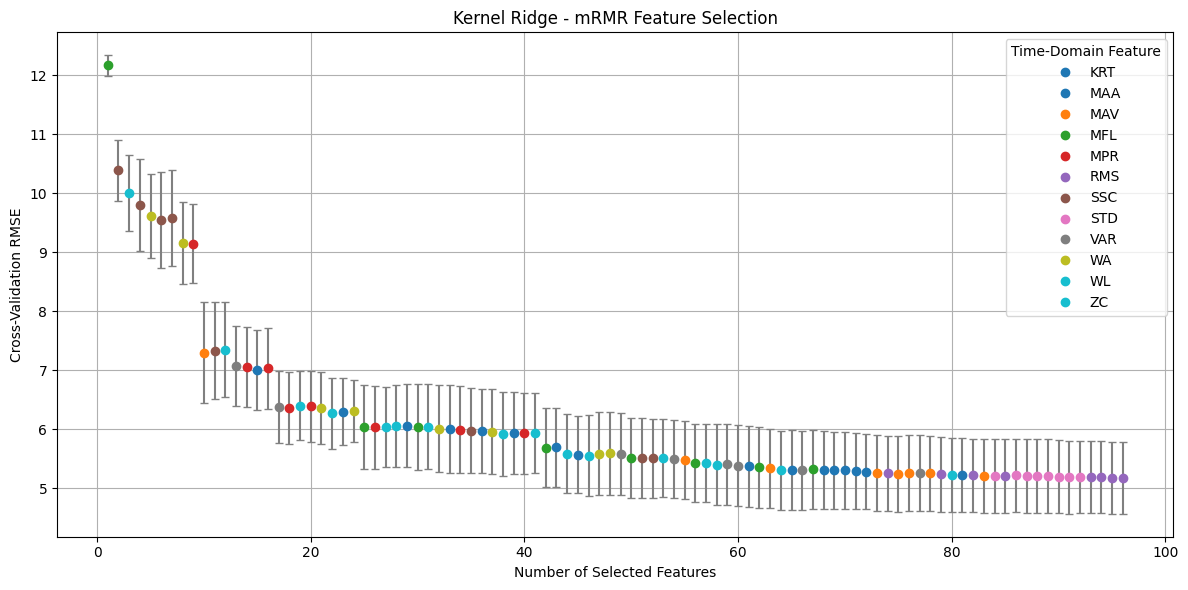

In [ ]:
from config.utils import plot_mrmr_results

# Plot mRMR Feature Selection
plot_mrmr_results(
    selected,
    CV_err_mrmr,
    td_feature_names=['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR',
                      'MAA', 'WL', 'SSC', 'WA', 'MFL', 'KRT'],
    model_name='Kernel Ridge'
)

In [9]:
from config.validation import mutual_info_corr, compute_mi_vector, greedy_mrmr_selection
from config.transformers import FeatureSelector

# Compute Mutual Info (includes feature extraction)
X_df, Y_all, mi_scores, X_sessions = compute_mi_vector(X_train_val_folds, Y_train_val_folds, TimeDomainTransformer(sigma_mpr=0.3))

# Perform mRMR
selected = greedy_mrmr_selection(X_df, mi_scores)

# Evaluation
n_features = len(selected)
n_sessions = X_sessions.shape[0]
CV_err_mrmr = np.zeros((n_features, n_sessions))

for nb_features in range(1, n_features + 1):
    selected_indices = selected[:nb_features]
    pipeline = Pipeline([
        ('select', FeatureSelector(selected_indices)),
        ('scale', StandardScaler()),
        ('reg', KNeighborsRegressor(
            n_neighbors = 5))
    ])
    cv_results = cross_validate_pipeline(
        pipeline, 
        X_sessions, 
        Y_train_val_folds,
        metric_fns={'RMSE': RMSE}, 
        n_folds=n_sessions, 
        verbose=0
    )
    for fold_id in range(n_sessions):
        CV_err_mrmr[nb_features - 1, fold_id] = cv_results[fold_id]['val_RMSE']

# Report results
print("\nmRMR Feature Selection with KNN")
for i in range(n_features):
    print(f"#Features: {i+1}; CV error = {CV_err_mrmr[i,:].mean():.4f}; std dev = {CV_err_mrmr[i,:].std():.4f}")

print("\nSelected feature ranking (by column index):")
print(selected)


mRMR Feature Selection with KNN
#Features: 1; CV error = 13.2282; std dev = 0.1855
#Features: 2; CV error = 11.1306; std dev = 0.5925
#Features: 3; CV error = 10.5179; std dev = 0.8145
#Features: 4; CV error = 10.1012; std dev = 1.1634
#Features: 5; CV error = 9.7119; std dev = 0.9338
#Features: 6; CV error = 9.5014; std dev = 0.9583
#Features: 7; CV error = 9.5535; std dev = 1.1317
#Features: 8; CV error = 9.1052; std dev = 0.9159
#Features: 9; CV error = 8.9546; std dev = 0.9007
#Features: 10; CV error = 7.0679; std dev = 0.8932
#Features: 11; CV error = 7.0507; std dev = 0.8194
#Features: 12; CV error = 7.2098; std dev = 0.7892
#Features: 13; CV error = 7.1682; std dev = 0.7574
#Features: 14; CV error = 6.9093; std dev = 0.8953
#Features: 15; CV error = 6.7399; std dev = 0.9708
#Features: 16; CV error = 6.8071; std dev = 0.9136
#Features: 17; CV error = 6.4845; std dev = 0.9391
#Features: 18; CV error = 6.5491; std dev = 0.9249
#Features: 19; CV error = 6.6354; std dev = 0.8044
#Fe

C:\Users\gianm\AppData\Local\Temp\ipykernel_50676\2031987167.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_types))


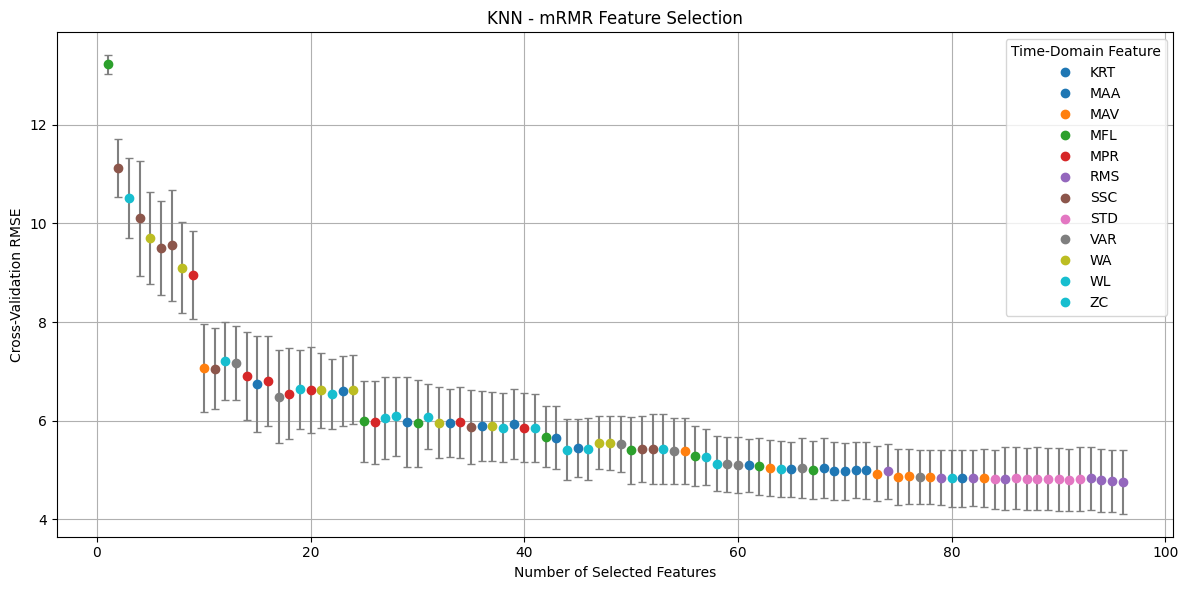

In [ ]:
# Plot mRMR Feature Selection
plot_mrmr_results(
    selected,
    CV_err_mrmr,
    td_feature_names=['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR',
                      'MAA', 'WL', 'SSC', 'WA', 'MFL', 'KRT'],
    model_name='KNN'
)

We evaluated RMSE across varying numbers of selected features using leave-one-session-out cross-validation. Here are the results near the optimal region (number reported for Kernel Ridge):
```text
#Features: 80; CV error = 5.2161; std dev = 0.6287  
#Features: 81; CV error = 5.2204; std dev = 0.6276  
#Features: 82; CV error = 5.2140; std dev = 0.6210  
#Features: 85; CV error = 5.2095; std dev = 0.6255  
#Features: 90; CV error = 5.1963; std dev = 0.6175  
#Features: 95; CV error = 5.1783; std dev = 0.6114  
#Features: 96; CV error = 5.1763; std dev = 0.6115  
```
The results show that after 80 features, additional features provide very marginal improvements in RMSE. This is visually confirmed in the plots "Regressor – mRMR Feature Selection".

To integrate feature selection directly into the learning pipeline, we implemented the TopKMRMRSelector class as a custom scikit-learn transformer. This enables end-to-end model training and evaluation without requiring separate preprocessing steps.
By setting k=80, we include only the most relevant features identified by mRMR, improving interpretability and reducing the dimensionality of 16 dimensions.

In [8]:
from config.transformers import TopKMRMRSelector

baseline_guided_kr = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('feature_select', TopKMRMRSelector(k=80)),
        ('regressor', KernelRidge(
            alpha = 0.01,
            gamma = 0.01,
            kernel='laplacian'))
    ]
)

baseline_guided_knn = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('feature_select', TopKMRMRSelector(k=80)),
        ('regressor', KNeighborsRegressor(
            n_neighbors = 5))
    ]
)

# Evaluation
metric_fns = {'RMSE': RMSE, 'NMSE': NMSE}
models = {
    'Time domain features + Kernel Ridge': baseline_guided_kr,
    'Time domain features + KNN': baseline_guided_knn,
}

for model_name, model in models.items():
    print(f'\nModel: {model_name}')
    result = cross_validate_pipeline(model, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=1)


Model: Time domain features + Kernel Ridge

Average Scores across folds:
RMSE: train=0.2133, val=5.2239
NMSE: train=0.0002, val=0.1380

Model: Time domain features + KNN

Average Scores across folds:
RMSE: train=2.1727, val=4.8403
NMSE: train=0.0235, val=0.1182


##### PCA
This section explains how **Principal Component Analysis (PCA)** is used as a feature selection and dimensionality reduction technique to improve regression performance from EMG time-domain features.

We evaluate PCA-based dimensionality reduction by retaining different levels of explained variance:

```python
variance_thresholds = np.arange(0.85, 0.991, 0.01)
```

For each subset of selected features from size 1 to N:
- Build a scikit-learn pipeline with the regressor
- Use cross_validate_pipeline() to compute the average RMSE across folds
- Evaluate mean Validation RMSE per fold
- Fit PCA separately to compute the actual number of components retained at that threshold

We generate two plots (as subplots in one figure):

- **RMSE vs. Variance Retained**: Shows how performance changes as we retain more principal components
- **Components vs. Variance Retained**: Visualizes the dimensionality reduction effect of PCA


Model Kernel Ridge
Variance: 0.85, RMSE: 5.3779, Components: 13
Variance: 0.86, RMSE: 5.3686, Components: 14
Variance: 0.87, RMSE: 5.3243, Components: 15
Variance: 0.88, RMSE: 5.3127, Components: 16
Variance: 0.89, RMSE: 5.2986, Components: 18
Variance: 0.90, RMSE: 5.3138, Components: 19
Variance: 0.91, RMSE: 5.2954, Components: 21
Variance: 0.92, RMSE: 5.2992, Components: 23
Variance: 0.93, RMSE: 5.3092, Components: 25
Variance: 0.94, RMSE: 5.3576, Components: 27
Variance: 0.95, RMSE: 5.3544, Components: 29
Variance: 0.96, RMSE: 5.3499, Components: 32
Variance: 0.97, RMSE: 5.3893, Components: 36
Variance: 0.98, RMSE: 5.3679, Components: 41
Variance: 0.99, RMSE: 5.3560, Components: 48


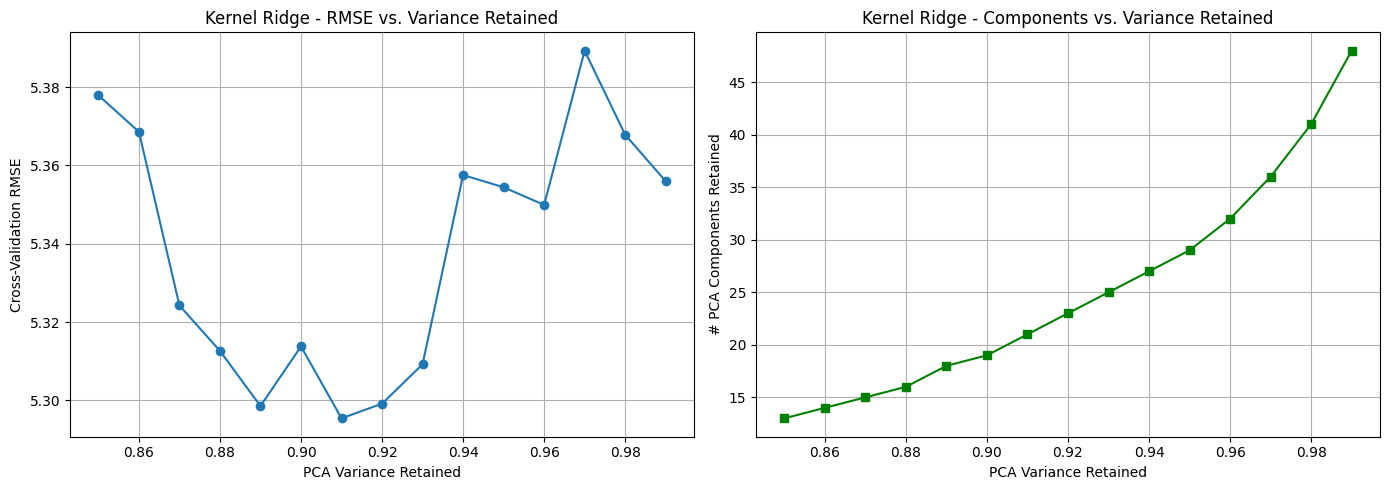

In [40]:
# Prepare inputs
from sklearn.decomposition import PCA

n_sessions, n_windows, n_channels, window_size = X_train_val_folds.shape

# Sweep PCA variance thresholds
variance_thresholds = np.arange(0.85, 0.991, 0.01)
nmse_scores = []
n_components_used = []

print("\nModel Kernel Ridge")
for var in variance_thresholds:
    pipeline = Pipeline([
        ('td_feat', TimeDomainTransformer()),
        ('scale', StandardScaler()),
        ('pca', PCA(n_components=float(var), random_state=42)),
        ('reg', KernelRidge(
            alpha = 0.01,
            gamma = 0.01,
            kernel='laplacian'))
    ])

    metric_fns = {'RMSE': RMSE}
    results = cross_validate_pipeline(
        pipeline,
        X_train_val_folds,
        Y_train_val_folds,
        metric_fns=metric_fns,
        verbose=0
    )

    # Fit once to extract # of components
    pipeline.fit(X_train_val_folds.reshape(-1, n_channels, window_size), Y_train_val_folds.reshape(-1, 51))
    n_comp = pipeline.named_steps['pca'].n_components_

    nmse_scores.append(results['avg_val_RMSE'])
    n_components_used.append(n_comp)

    print(f"Variance: {var:.2f}, RMSE: {results['avg_val_RMSE']:.4f}, Components: {n_comp}")

# Plots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: RMSE vs Variance Retained
axs[0].plot(variance_thresholds, nmse_scores, marker='o')
axs[0].set_xlabel("PCA Variance Retained")
axs[0].set_ylabel("Cross-Validation RMSE")
axs[0].set_title("Kernel Ridge - RMSE vs. Variance Retained")
axs[0].grid(True)

# Plot 2: #Components vs Variance Retained
axs[1].plot(variance_thresholds, n_components_used, marker='s', color='green')
axs[1].set_xlabel("PCA Variance Retained")
axs[1].set_ylabel("# PCA Components Retained")
axs[1].set_title("Kernel Ridge - Components vs. Variance Retained")
axs[1].grid(True)

plt.tight_layout()
plt.show()


Model KNN
Variance: 0.85, RMSE: 4.6828, Components: 13
Variance: 0.86, RMSE: 4.7069, Components: 14
Variance: 0.87, RMSE: 4.6806, Components: 15
Variance: 0.88, RMSE: 4.7006, Components: 16
Variance: 0.89, RMSE: 4.7275, Components: 18
Variance: 0.90, RMSE: 4.7079, Components: 19
Variance: 0.91, RMSE: 4.6922, Components: 21
Variance: 0.92, RMSE: 4.6976, Components: 23
Variance: 0.93, RMSE: 4.6790, Components: 25
Variance: 0.94, RMSE: 4.6994, Components: 27
Variance: 0.95, RMSE: 4.7007, Components: 29
Variance: 0.96, RMSE: 4.7096, Components: 32
Variance: 0.97, RMSE: 4.7091, Components: 36
Variance: 0.98, RMSE: 4.7052, Components: 41
Variance: 0.99, RMSE: 4.6980, Components: 48


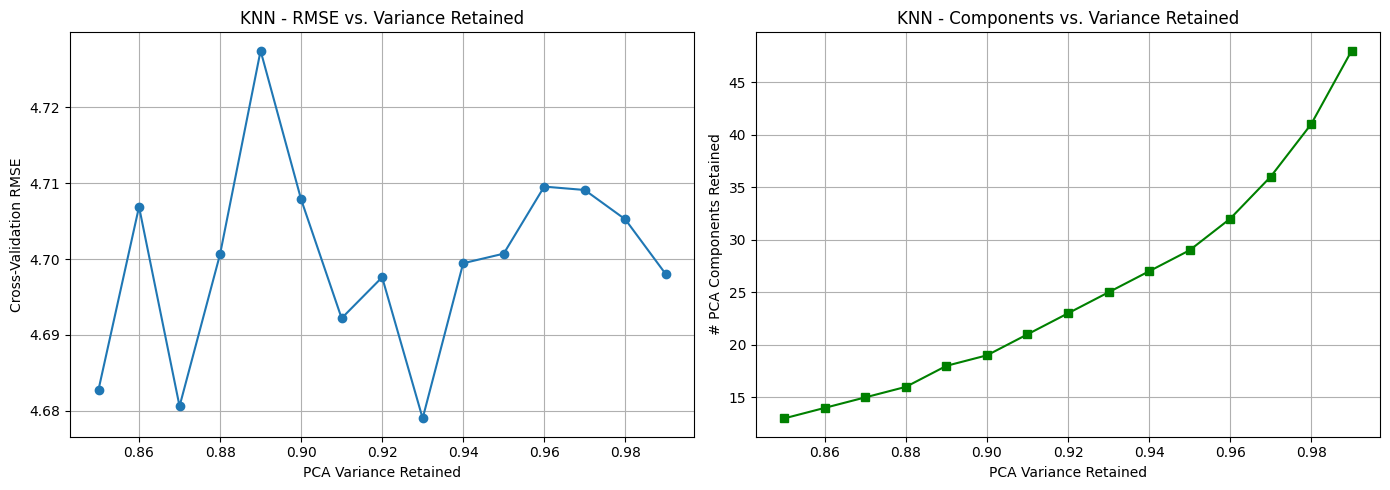

In [41]:
# Sweep PCA variance thresholds
variance_thresholds = np.arange(0.85, 0.991, 0.01)
nmse_scores = []
n_components_used = []

print("\nModel KNN")
for var in variance_thresholds:
    pipeline = Pipeline([
        ('td_feat', TimeDomainTransformer()),
        ('scale', StandardScaler()),
        ('pca', PCA(n_components=float(var), random_state=42)),
        ('reg', KNeighborsRegressor(
            n_neighbors = 5))
    ])

    metric_fns = {'RMSE': RMSE}
    results = cross_validate_pipeline(
        pipeline,
        X_train_val_folds,
        Y_train_val_folds,
        metric_fns=metric_fns,
        verbose=0
    )

    # Fit once to extract # of components
    pipeline.fit(X_train_val_folds.reshape(-1, n_channels, window_size), Y_train_val_folds.reshape(-1, 51))
    n_comp = pipeline.named_steps['pca'].n_components_

    nmse_scores.append(results['avg_val_RMSE'])
    n_components_used.append(n_comp)

    print(f"Variance: {var:.2f}, RMSE: {results['avg_val_RMSE']:.4f}, Components: {n_comp}")

# Plots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: RMSE vs Variance Retained
axs[0].plot(variance_thresholds, nmse_scores, marker='o')
axs[0].set_xlabel("PCA Variance Retained")
axs[0].set_ylabel("Cross-Validation RMSE")
axs[0].set_title("KNN - RMSE vs. Variance Retained")
axs[0].grid(True)

# Plot 2: #Components vs Variance Retained
axs[1].plot(variance_thresholds, n_components_used, marker='s', color='green')
axs[1].set_xlabel("PCA Variance Retained")
axs[1].set_ylabel("# PCA Components Retained")
axs[1].set_title("KNN - Components vs. Variance Retained")
axs[1].grid(True)

plt.tight_layout()
plt.show()

TO-DO: Explain which threshold we pick for PCA and why

## (2 points) More sophisticated approach
Implement a regression model based on either the covariance matrices (3.2) pipeline described above or a neural network approach using the PyTorch library. Optionally, you can implement both approaches. Assess its cross-validated performance with respect to the baseline approach and discuss the results. The use of figures, formulas, tables and pseudo-code to describe this approach is again strongly encouraged. Note that one-third of the score will depend on the quality and clarity of your documentation.

### Riemannian Geometry-Based Pipelines 
These pipelines use the geometry of covariance matrices to extract robust features from multichannel EMG signals. Leveraging **Riemannian geometry**, this method is well-suited for structured signals like EEG or EMG.

Common Pipeline structure:

1. **Covariance Estimation**  
   `pyriemann.estimation.Covariances()`  
   - Computes the covariance matrix from EMG channels per time window.

2. **Tangent Space Projection**  
   `pyriemann.tangentspace.TangentSpace(metric='riemann', tsupdate=True)`  
   - Projects the SPD matrices onto the tangent space at the Riemannian mean.
   - `tsupdate=True` allows updating the tangent space mean at transform time.

3. **Feature Scaling**  
   `StandardScaler()`  
   - Standard normalization to mean 0 and unit variance.

4. **Regression Model**  
   - Varies across pipelines below.

As regression model we used:
- Kernel Ridge
- KNN
- Random Forest

E.g.: Kernel Ridge Regression
```python
riem1 = Pipeline([
    ('feature_extraction', Covariances()),
    ('transformation', TangentSpace(metric='riemann', tsupdate=True)),
    ('scaler', StandardScaler()),
    ('regressor', KernelRidge(
            alpha=0.01, 
            gamma=0.01, 
            kernel='laplacian'))
])

In [8]:
import pyriemann
import pyriemann.regression
from sklearn.multioutput import MultiOutputRegressor

In [9]:
# Riemannian geometry of covariance matrices
riem1 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('scaler', StandardScaler()),
        ('regressor', KernelRidge(
            alpha = 0.01,
            gamma = 0.01,
            kernel='laplacian'))
    ]
)

riem2 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('scaler', StandardScaler()),
        ('regressor', KNeighborsRegressor(
            n_neighbors = 5))
    ]
)

riem3 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(
            n_estimators = 50,
            max_depth = 10))
    ]
)

In [10]:
# Evaluation
metric_fns = {'RMSE': RMSE, 'NMSE': NMSE}
models = {
    'Riemann + Kernel Ridge': riem1,
    'Riemann + KNN': riem2,
    'Riemann + Random Forest': riem3
}

for model_name, model in models.items():
    print(f'\nModel: {model_name}')
    result = cross_validate_pipeline(model, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=1)


Model: Riemann + Kernel Ridge

Average Scores across folds:
RMSE: train=0.5305, val=5.5466
NMSE: train=0.0014, val=0.1548

Model: Riemann + KNN

Average Scores across folds:
RMSE: train=3.2994, val=5.8645
NMSE: train=0.0543, val=0.1764

Model: Riemann + Random Forest

Average Scores across folds:
RMSE: train=2.1553, val=4.8815
NMSE: train=0.0232, val=0.1216


## 🧠 Domain-Adversarial Neural Network (DANN)

<br>

---

<br>


### 🧭 Approach — Substantiating the Use of DANN

In EMG-based regression, **inter-session variability** presents a key challenge to generalisation. Signals can differ substantially across recording sessions due to factors such as:

- Electrode placement drift
- Muscle fatigue or tension variation
- Electrical noise or impedance shifts
- Skin conductivity changes over time

Even when gestures are performed identically, the signal shapes and amplitudes can vary — this is clearly visible when comparing sessions directly.

---

#### 🔍 Empirical Motivation: Session Variability

To substantiate the use of domain-adversarial learning, we first note that our **baseline models exhibit poor cross-session generalisation**:  
cross-validation performance shows **one fold significantly underperforming the others**, suggesting that the model overfits to session-specific features.

Rather than relying solely on loss metrics, we visually highlight this phenomenon.

We propose computing a **per-session signal profile summary**, using variance or magnitude-based time features (e.g., mean absolute value, waveform length, etc.) aggregated over all windows and channels. This provides a condensed summary of the **typical signal signature** for each session.

**Suggested visualisation:** - TEMPORARY
- A grid of plots — one per session — each showing a compact summary (e.g., channel-wise MAV or RMS curves over time)
- This allows direct visual comparison of **how sessions differ globally**, while avoiding the complexity of deeper classifiers

Such a summary figure helps confirm that:
- Each session indeed has a **distinct signal signature**
- Domain shifts are large enough to justify using a **domain-adversarial approach**

In this context, DANN becomes essential: it penalises representations that retain session identity and enforces learning of **shared signal structure**, not session-specific noise.

---

#### ❓ Why Domain-Adversarial Neural Networks (DANN)?

Rather than rely on classical regularisation alone, we use **domain-adversarial training** to penalise representations that encode session-specific information.

**Principle:**  
> If a feature extractor allows a domain classifier to easily identify which session a signal comes from, then it is learning features that are not session-invariant.  
> DANN flips the gradients from the domain classifier to *discourage* such behaviour.

By integrating a **domain classifier and gradient reversal layer**, we force the network to **learn features that generalise across sessions**, leading to more robust predictions even on unseen recordings.

---

#### 🧠 Why a CNN for Feature Extraction?

Convolutional Neural Networks (CNNs) are well-suited to modelling **temporal and spatial patterns** in time-series data like EMG. The reasons are:

- They can detect **local patterns** (e.g. bursts or waves) that correspond to muscle activation
- They **share weights** across time, ensuring translation-invariance
- They efficiently extract features over long time windows (e.g. 500ms) without exploding parameter counts

This makes CNNs particularly effective for EMG feature extraction, especially when combined with DANN to learn session-agnostic representations.

---    
   
<br>





## Model explainer

<br>

The DANN model used in this project consists of three key components:

<br>

---

<br>

>  ### 1. Feature Extractor (CNN)
> 
> - **Purpose:** Converts the raw multi-channel EMG signal into a compact latent representation that captures relevant temporal features.
> - **Input:** A tensor of shape `(batch_size, channels, time)`, typically including the raw signal and its first derivative.
> - **Architecture:** A stack of 1D convolutional layers with ReLU activation, batch normalization, dropout, and pooling.
> - **Output:** A feature vector of fixed size (e.g. 128-dim), serving as the input to both the regressor and the domain classifier.
> 
> This block is responsible for **capturing spatial and temporal correlations** in EMG signals while being general enough to apply across recording sessions.
> 
> 
> ### 2. Regressor Head
> 
> - **Purpose:** Predicts the 51-dimensional vector of joint angles from the extracted feature representation.
> - **Input:** The latent feature vector from the feature extractor.
> - **Output:** A continuous prediction for each joint angle.
> 
> While this module is evaluated using **Mean Squared Error (MSE)** on joint angle predictions, it is not trained in isolation — it is optimised jointly as part of a broader loss function that includes domain adaptation objectives.
> 
> 
> ### 3. Domain Classifier + Gradient Reversal Layer (GRL)
> 
> - **Purpose:** Attempts to classify which session the input signal came from.
> - **Architecture:** A lightweight classifier (e.g., MLP) producing a probability distribution over the session domain labels.
> - **Gradient Reversal Layer (GRL):** During backpropagation, the GRL inverts the gradient signal coming from the domain classifier. This encourages the feature extractor to **remove session-specific information**.
> 
> By penalising features that allow easy domain classification, the feature extractor is encouraged to learn **session-invariant representations**, improving generalisation.


<br>

---

### 🔄 Training Strategy

The DANN model is trained using a **composite loss function** that balances prediction accuracy and domain invariance. Specifically, the model minimises the following total loss:

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{reg}} + \lambda \cdot \mathcal{L}_{\text{domain}} - \gamma \cdot \mathcal{H}(\text{domain\_pred})
$$

Where:
> 
> - $\mathcal{L}_{\text{reg}}$: Mean Squared Error (MSE) between predicted and true joint angles  
> - $\mathcal{L}_{\text{domain}}$: Cross-entropy loss on predicted session (domain)  
> - $\mathcal{H}$: Shannon entropy of the domain prediction distribution (optional regulariser)  
> - $\lambda$: Adversarial weighting factor (annealed from 0 to 1)  
> - $\gamma$: Entropy regularisation coefficient (typically small, e.g. 0.05–0.1)
> 
> <br>
> 
> At each iteration during training:
> 
> 1. The EMG input $x$ is passed through the **feature extractor**, producing latent features.
> 2. These features are passed to:
>    - The **regressor**, which outputs joint angle predictions $\hat{y}$
>    - The **domain classifier**, via a **Gradient Reversal Layer**, which outputs session prediction logits
> 3. The three loss components are computed and combined into the total loss.
> 4. A single backward pass updates all parameters jointly, with the GRL flipping gradients flowing into the feature extractor from the domain classifier.
> 
> The objective is to extract features that:
> - Enable accurate joint angle prediction  
> - Obscure session identity, promoting session-invariant learning

<br>

---

## 🔧 DANN Code Components — Overview & Usage Guide

---

### 🧠 `DANNModel`

> `class DANNModel(nn.Module)`

**Purpose:**  
Defines the core Domain-Adversarial Neural Network architecture. It encapsulates the three key submodules:

1. `ConvFeatureExtractor`:  
   CNN-based block transforming EMG windows of shape `(batch_size, 8, 500)` into compact 128-dim features.

2. `RegressorHead`:  
   Fully connected layers that map latent features to the 51 joint-angle outputs.

3. `DomainDiscriminator`:  
   Lightweight classifier (MLP) to predict session identity. Connected via a **Gradient Reversal Layer (GRL)** to encourage domain-invariant feature learning.

**Key Parameters:**

- `lambda_grl` *(float)*: Weight of gradient reversal in the adversarial loss. Passed at each forward pass.
- `num_domains` *(int)*: Number of different session labels for the domain classifier.
- `output_dim` *(int)*: Number of regression outputs (default is 51 joint angles).

**How It Connects:**  
- Used directly in `DANNTrainer` to construct and forward the model.
- May be swapped with `TemporalDANNModel` for more advanced architectures.

---

### 🧪 `DANNTrainer`

> `class DANNTrainer`

**Purpose:**  
Manages the full training loop for DANN, including:

- Gradient reversal and joint optimisation of regression + domain losses
- Cross-session early stopping
- Composite loss:  
  $$
  \mathcal{L}_{\text{total}} = \mathcal{L}_{\text{reg}} + \lambda \cdot \mathcal{L}_{\text{domain}} - \gamma \cdot \mathcal{H}
  $$

**Key Arguments:**

- `model` *(nn.Module)*: Must follow the DANN interface (e.g., return both regression and domain outputs).
- `train_loader`, `val_loader`: PyTorch `DataLoader` objects for training/validation.
- `lambda_grl`: Strength of the gradient reversal loss component (annealed across epochs).
- `gamma_entropy`: Optional entropy regularisation to encourage uniform domain predictions.
- `max_epochs`, `patience`: Control training loop and early stopping.
- `device`: Typically `"cuda"` or `"cpu"`.

**Core Methods:**

- `.train()`: Trains with early stopping on validation RMSE.
- `.predict(data_loader)`: Forward pass on new data.
- `.evaluate()`: Computes RMSE on validation set.
- `.evaluate_domain_on_train()`: Returns accuracy of domain predictions on training set — useful to diagnose invariance.

**How It Connects:**  
Instantiated in both `DANNRegressor` and cross-validation functions. Can be reused manually for experiments.

---

### 🔁 `cross_validate_dann`

> `def cross_validate_dann(...)`

**Purpose:**  
Automates session-wise **leave-one-session-out** cross-validation for DANN training.

**Workflow:**

1. Splits the 5 sessions into 4 training and 1 validation.
2. Constructs appropriate session IDs for domain classification.
3. Trains a new `DANNModel` per fold with fresh `DANNTrainer`.
4. Aggregates RMSE scores across folds.

**Key Arguments:**

- `X`, `Y`: EMG windows and joint-angle labels of shape `(5, N_w, C, T)` and `(5, N_w, 51)`.
- `tensor_dataset`: Dataset wrapper (e.g., `DANNWindowTensor`) that flattens sessions and attaches session labels.
- `lambda_grl`, `gamma`, `batch_size`, `max_epochs`, `patience`: Training hyperparameters.
- `num_domains`: Typically 5 (number of sessions).

**Output:**  
A list of RMSE scores per fold. Prints average and standard deviation.

**How It Connects:**  
Ideal for comparing DANN to other models under consistent validation logic. Supports swapping architectures (e.g., `TemporalDANNModel` via `cross_validate_tempdann`).

---




In [4]:
from config.dann import DataLoader, DANNModel, DANNTrainer, DANNWindowTensor, DANNRegressor, DANNConfig, DANNRunner, torch, TemporalDANNModel
from config.validation import RMSE, NMSE

### DANN Neural Network: 4-Fold cross validation
---


=== Fold 1 | Train on [1, 2, 3], Validate on 0 ===
Epoch 001 | Train Loss: 27.2569 | Val Loss: 24.7986 | Dom Train Acc: 0.74%
Epoch 002 | Train Loss: 26.9848 | Val Loss: 24.5620 | Dom Train Acc: 20.39%
Epoch 003 | Train Loss: 26.6854 | Val Loss: 24.2679 | Dom Train Acc: 23.73%
Epoch 004 | Train Loss: 26.3364 | Val Loss: 24.0953 | Dom Train Acc: 23.08%
Epoch 005 | Train Loss: 25.9610 | Val Loss: 23.7532 | Dom Train Acc: 31.88%
Epoch 006 | Train Loss: 25.5637 | Val Loss: 23.3688 | Dom Train Acc: 35.03%
Epoch 007 | Train Loss: 25.1471 | Val Loss: 23.5641 | Dom Train Acc: 19.46%
Epoch 008 | Train Loss: 24.7201 | Val Loss: 23.0458 | Dom Train Acc: 21.32%
Epoch 009 | Train Loss: 24.2688 | Val Loss: 22.4061 | Dom Train Acc: 25.95%
Epoch 010 | Train Loss: 23.8320 | Val Loss: 21.6436 | Dom Train Acc: 32.62%
Epoch 011 | Train Loss: 23.3595 | Val Loss: 21.5124 | Dom Train Acc: 31.14%
Epoch 012 | Train Loss: 22.9540 | Val Loss: 19.9015 | Dom Train Acc: 18.07%
Epoch 013 | Train Loss: 22.4214 | Val

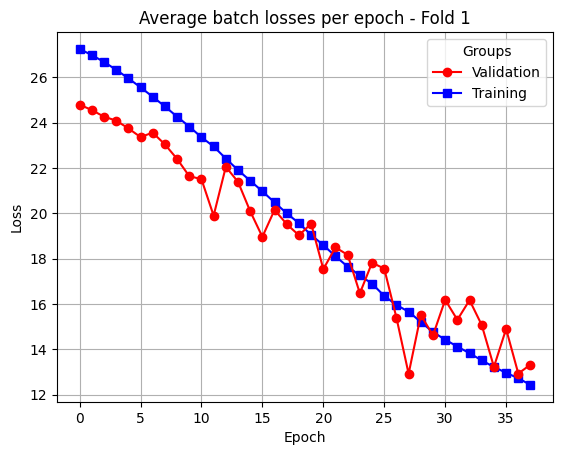


Fold 1
RMSE: train=12.4345, val=13.3316
NMSE: train=0.8797, val=1.3373

=== Fold 2 | Train on [0, 2, 3], Validate on 1 ===
Epoch 001 | Train Loss: 24.8104 | Val Loss: 31.4102 | Dom Train Acc: 0.00%
Epoch 002 | Train Loss: 24.5407 | Val Loss: 30.9174 | Dom Train Acc: 0.19%
Epoch 003 | Train Loss: 24.2401 | Val Loss: 30.4251 | Dom Train Acc: 1.76%
Epoch 004 | Train Loss: 23.9062 | Val Loss: 29.8913 | Dom Train Acc: 10.47%
Epoch 005 | Train Loss: 23.5227 | Val Loss: 30.0313 | Dom Train Acc: 4.26%
Epoch 006 | Train Loss: 23.1218 | Val Loss: 29.0493 | Dom Train Acc: 6.39%
Epoch 007 | Train Loss: 22.6959 | Val Loss: 28.7538 | Dom Train Acc: 14.46%
Epoch 008 | Train Loss: 22.2849 | Val Loss: 27.9024 | Dom Train Acc: 6.95%
Epoch 009 | Train Loss: 21.8374 | Val Loss: 28.1903 | Dom Train Acc: 11.21%
Epoch 010 | Train Loss: 21.4257 | Val Loss: 27.2834 | Dom Train Acc: 15.85%
Epoch 011 | Train Loss: 20.9780 | Val Loss: 27.2999 | Dom Train Acc: 10.29%
Epoch 012 | Train Loss: 20.5306 | Val Loss: 25

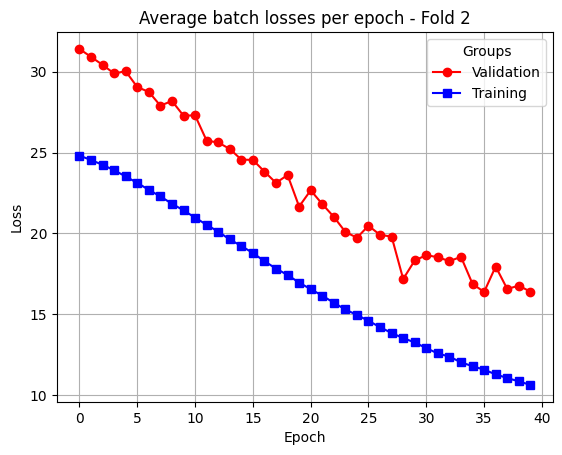


Fold 2
RMSE: train=10.6278, val=16.3964
NMSE: train=0.7809, val=1.4689

=== Fold 3 | Train on [0, 1, 3], Validate on 2 ===
Epoch 001 | Train Loss: 26.8209 | Val Loss: 26.2795 | Dom Train Acc: 0.00%
Epoch 002 | Train Loss: 26.5474 | Val Loss: 25.9785 | Dom Train Acc: 17.79%
Epoch 003 | Train Loss: 26.2445 | Val Loss: 25.6616 | Dom Train Acc: 11.49%
Epoch 004 | Train Loss: 25.9239 | Val Loss: 25.2842 | Dom Train Acc: 7.60%
Epoch 005 | Train Loss: 25.5597 | Val Loss: 24.5011 | Dom Train Acc: 2.32%
Epoch 006 | Train Loss: 25.1821 | Val Loss: 23.8412 | Dom Train Acc: 4.63%
Epoch 007 | Train Loss: 24.7871 | Val Loss: 23.2399 | Dom Train Acc: 4.36%
Epoch 008 | Train Loss: 24.3556 | Val Loss: 23.4219 | Dom Train Acc: 24.37%
Epoch 009 | Train Loss: 23.9492 | Val Loss: 23.5357 | Dom Train Acc: 35.22%
Epoch 010 | Train Loss: 23.4899 | Val Loss: 23.2401 | Dom Train Acc: 43.93%
Epoch 011 | Train Loss: 23.0254 | Val Loss: 22.6022 | Dom Train Acc: 27.53%
Epoch 012 | Train Loss: 22.5674 | Val Loss: 2

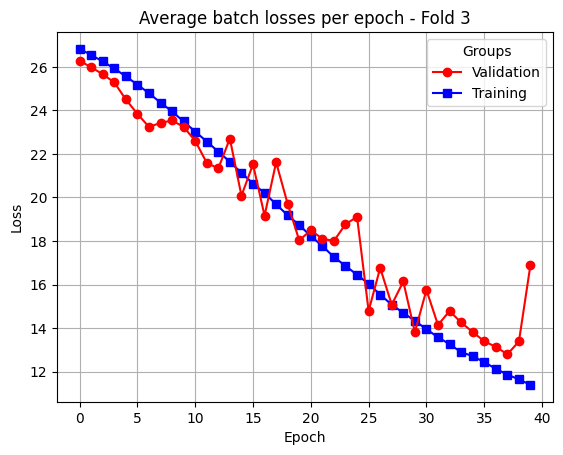


Fold 3
RMSE: train=11.3909, val=16.9110
NMSE: train=0.7919, val=1.6466

=== Fold 4 | Train on [0, 1, 2], Validate on 3 ===
Epoch 001 | Train Loss: 27.6361 | Val Loss: 23.5083 | Dom Train Acc: 0.00%
Epoch 002 | Train Loss: 27.3783 | Val Loss: 23.2008 | Dom Train Acc: 0.00%
Epoch 003 | Train Loss: 27.0821 | Val Loss: 22.6370 | Dom Train Acc: 0.00%
Epoch 004 | Train Loss: 26.7503 | Val Loss: 22.3427 | Dom Train Acc: 0.00%
Epoch 005 | Train Loss: 26.3892 | Val Loss: 22.0480 | Dom Train Acc: 0.00%
Epoch 006 | Train Loss: 25.9923 | Val Loss: 22.1824 | Dom Train Acc: 0.00%
Epoch 007 | Train Loss: 25.5695 | Val Loss: 21.5018 | Dom Train Acc: 0.00%
Epoch 008 | Train Loss: 25.1328 | Val Loss: 20.6949 | Dom Train Acc: 0.00%
Epoch 009 | Train Loss: 24.6845 | Val Loss: 21.3320 | Dom Train Acc: 0.00%
Epoch 010 | Train Loss: 24.2310 | Val Loss: 20.6243 | Dom Train Acc: 0.00%
Epoch 011 | Train Loss: 23.7360 | Val Loss: 20.5179 | Dom Train Acc: 0.00%
Epoch 012 | Train Loss: 23.2864 | Val Loss: 20.1473

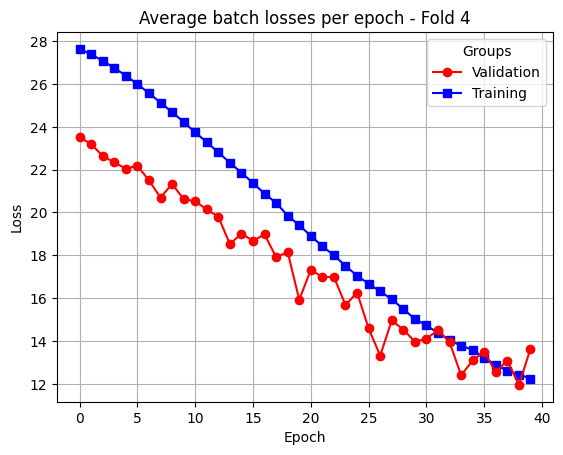


Fold 4
RMSE: train=12.2474, val=13.6365
NMSE: train=0.8511, val=1.5859

Average Scores across folds:
RMSE: train=11.6752, val=15.0689
NMSE: train=0.8259, val=1.5097


In [5]:
config = DANNConfig(
    batch_size=256,
    max_epochs=40,
    patience=10,
    learning_rate=1e-3,
    lambda_grl=1.0,
    gamma_entropy=0.05,
    num_domains=4,
    output_dim=51,
    device="cuda" if torch.cuda.is_available() else "cpu",
    verbose=1  # verbose=2 for epoch logs
)


runner = DANNRunner(
    model_class=lambda **kwargs: DANNModel(**kwargs),
    dataset_class=DANNWindowTensor,
    config=config
)

results = runner.cross_validate(X_freemoves_windows[:4], Y_freemoves_labels[:4])

In [7]:


# Prepare session ID vector (e.g. 0,0,...,1,1,...,2,...)
train_session_ids = np.concatenate([
    np.full(X_freemoves_windows[s].shape[0], s) for s in range(4)
])

# Create model instance
model = DANNModel(
    lambda_grl=1.0,  # this is passed into the config too
    num_domains=4,
    output_dim=51
)

# Wrap model in regressor
regressor = DANNRegressor(
    model=model,
    session_ids=train_session_ids,
    dataset_class=DANNWindowTensor,
    gamma_entropy=0.1,
    max_epochs=5,
    patience=3,
    device="cuda",
    verbose=True
)

# Fit model
regressor.fit(X_freemoves_windows[:4], Y_freemoves_labels[:4])

# Predict on held-out session
preds = regressor.predict(X_freemoves_windows[4])

# Evaluate
print("Held-out RMSE:", RMSE(preds, Y_freemoves_labels[4]))
print("Held-out NMSE:", NMSE(preds, Y_freemoves_labels[4]))


Epoch 001 | Train Loss: 26.4823
Epoch 002 | Train Loss: 25.6788
Epoch 003 | Train Loss: 24.6675
Epoch 004 | Train Loss: 23.5974
Epoch 005 | Train Loss: 22.4162
Held-out RMSE: 16.95826512153341
Held-out NMSE: 2.5845266894311085


In [10]:


# Load Model and session labels (indices)
train_session_ids = np.concatenate([np.full(X_freemoves_windows[:4][s].shape[0], s) for s in range(4)])

model = DANNModel(
    lambda_grl=1.0,
    num_domains=4,
    output_dim=51,
)

# Wrap into scikit-learn-style regressor
regressor = DANNRegressor(
    model=model,
    session_ids=train_session_ids,
    dataset_class=DANNWindowTensor,
    gamma_entropy=0.1,
    max_epochs=65,
    patience=10,
    device="cuda",
)

# Fit on sessions 0 to 4
regressor.fit(X_freemoves_windows[:4], Y_freemoves_labels[:4])

# Predict on session 5
X_heldout_tensor = torch.tensor(X_freemoves_windows[4], dtype=torch.float32)
preds = regressor.predict(X_freemoves_windows[4])

# Evaluation

print("Held-out RMSE:", RMSE(preds, Y_freemoves_labels[4]))
print("Held-out NMSE:", NMSE(preds, Y_freemoves_labels[4]))

TypeError: DANNTrainer.__init__() got an unexpected keyword argument 'config'

## (3 points) Ensemble
Design and implement two ensembling strategies that combine the predictions of all individual regression models you implemented, each independently trained on distinct feature representations of the EMG signals. The two required ensembling approaches are the following:
- Compute the average of the predicted values
- Use a meta-learner strategy (often referred to as stacking), in which a separate model—trained on the outputs of the base learners—generates the ensemble prediction
For each ensemble strategy, compare and document the ensemble’s regression performance against each of its constituent base models using consistent regression metrics. Additionally, for the metalearner strategy, determine and discuss the relative contribution of each base model to the final ensemble prediction. Discuss how the bias-variance tradeoff relates to the observed (or expected) evolution of performance.

### Ensemble regressors
TO-DO: add descripton

In [11]:
from config.regressors import VotingRegressor, StackingRegressor

In [12]:
voting_estimator = VotingRegressor(
    estimators = [
        baseline_guided_kr,
        baseline_guided_knn,
        baseline_guided_rf,
        riem1,
        riem2,
        riem3
    ]
)

result = cross_validate_pipeline(voting_estimator, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=2)


Fold 1
RMSE: train=1.3993, val=3.6947
NMSE: train=0.0097, val=0.0704

Fold 2
RMSE: train=1.3329, val=4.6125
NMSE: train=0.0088, val=0.1081

Fold 3
RMSE: train=1.3666, val=5.4712
NMSE: train=0.0095, val=0.1406

Fold 4
RMSE: train=1.3593, val=3.7139
NMSE: train=0.0091, val=0.0699

Average Scores across folds:
RMSE: train=1.3645, val=4.3731
NMSE: train=0.0093, val=0.0973


In [14]:
stacking_estimator = StackingRegressor(
    estimators = [
        baseline_guided_kr,
        baseline_guided_knn,
        baseline_guided_rf,
        riem1,
        riem2,
        riem3
    ],
    end_estimator = RandomForestRegressor(
        n_estimators = 50,
        max_depth = 10)
)

result = cross_validate_pipeline(stacking_estimator, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=2)


Fold 1
RMSE: train=0.6950, val=4.5792
NMSE: train=0.0024, val=0.1082

Fold 2
RMSE: train=0.6892, val=4.7098
NMSE: train=0.0024, val=0.1127

Fold 3
RMSE: train=0.6675, val=5.0928
NMSE: train=0.0023, val=0.1218

Fold 4
RMSE: train=0.6587, val=3.9426
NMSE: train=0.0021, val=0.0788

Average Scores across folds:
RMSE: train=0.6776, val=4.5811
NMSE: train=0.0023, val=0.1054


### Estimator validation

### Visualizing predictions to unseen data

In [ ]:
X_train_val_flat = X_train_val_folds.reshape(-1, *X_train_val_folds.shape[2:])
Y_train_val_flat = Y_train_val_folds.reshape(-1, *Y_train_val_folds.shape[2:])

model = ensemble_estimator

model.fit(X_train_val_flat, Y_train_val_flat)
Y_train_pred = model.predict(X_train_val_flat)
Y_test_pred = model.predict(X_test)

print(f"train RMSE:\t{RMSE(Y_train_pred, Y_train_val_flat):.4f}\ttrain NMSE:\t{NMSE(Y_train_pred, Y_train_val_flat):.4f}")
print(f"test RMSE:\t{RMSE(Y_test_pred, Y_test):.4f}\ttest NMSE:\t{NMSE(Y_test_pred, Y_test):.4f}")

In [ ]:
from config.utils import scatter_3d_points

bone = 6
Y_true_bone = Y_test[:,3*bone:3*(bone+1)]
Y_pred_bone = Y_test_pred[:,3*bone:3*(bone+1)]

print(f'RMSE for bone {bone}:', RMSE(Y_pred_bone, Y_true_bone))
print(f'NMSE for bone {bone}:', NMSE(Y_pred_bone, Y_true_bone))

ax = scatter_3d_points(Y_true_bone, color = 'b')
scatter_3d_points(Y_pred_bone, color = 'r', ax = ax)
# ax.set_xlim3d(-50, 50)
# ax.set_ylim3d(-50, 50)
# ax.set_zlim3d(-50, 50)
plt.show()